In [4]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from imports import *
from session.sessions import selected_009266, selected_009265, selected_008229, selected_60, selected_57
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy.signal import filtfilt, butter, sosfilt, sosfreqz, lfilter
from session.adapters import DatProcessor
from target import get_spike_counts, build_silence_and_noise_events

%matplotlib inline

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
sessions = [s for s in selected_57]
sessions.sort()
sessions[:5]

['57_SIT_2023-12-18_14-07-34',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_14-43-58',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01']

## Calibrate LFP filtering before extraction

In [10]:
src_raw = '/home/sobolev/nevermind/AG_Pecka/data/raw/'
src_prc = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

session = sessions[-1]
session

'57_SIT_2024-01-15_14-34-48'

In [12]:
animal      = session.split('_')[0]
meta_file   = os.path.join(src_prc, animal, session, 'meta.h5')
lfp_file    = os.path.join(src_prc, animal, session, 'lfp.h5')
man_file    = os.path.join(src_raw, animal, session, 'manual.json')

with h5py.File(lfp_file, 'r') as f:
    lfp_mx = np.array(f['lfp'])

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])

with open(man_file) as json_file:
    channels = json.load(json_file)['AEPs']
    
channels

In [22]:
lfp = lfp_mx[:, channels['A1']]

# first cut out outliers (how?)
lfp[lfp >  4*lfp.std()] =  4*lfp.std()
lfp[lfp < -4*lfp.std()] = -4*lfp.std()

In [33]:
s_rate = 1000  # Hz
nyquist = 0.5 * s_rate

# try to filter 50Hz
low  = 47 / nyquist
high = 53 / nyquist
sos = signal.butter(10, [low, high], btype='bandstop', output='sos')
lfp_filt = signal.sosfiltfilt(sos, lfp)

# try to filter < 1Hz slow staff
h_cut = 1 / nyquist
sos = signal.butter(10, h_cut, btype='highpass', output='sos')
lfp_filt = signal.sosfiltfilt(sos, lfp_filt)


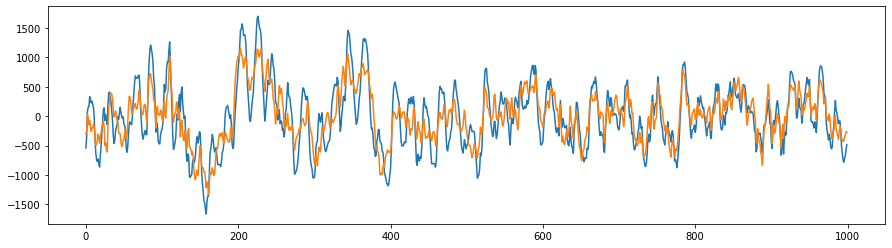

In [34]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(lfp[29000:30000])
ax.plot(lfp_filt[29000:30000])

In [18]:
3*lfp.std()

2028.0800947392217

In [35]:
s1 = 'aeps_11_250_filt'
s1.find('filt') > 1

True

## LFP extraction

In [6]:
def extract_lfp(source, session, area, channel):
    t_start = time.time()
    s_rate      = 30000
    down_s_rate = 1000
    
    animal      = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    dat_file    = os.path.join(sessionpath, session + '.dat')
    aeps_file   = os.path.join(sessionpath, 'AEPs.h5')

    dat_processor = DatProcessor(dat_file)
    
    # get raw signal from selected channel
    raw_signal = dat_processor.get_single_channel(channel, block_duration=10)

    # how much memory is the signal
    print((raw_signal.shape[0] * 2) / 1024**2)
    
    # bandpass filter 0.5 - 200
    low_cut, high_cut = 0.5, 200
    filt_signal = DatProcessor.butter_bandpass_filter(raw_signal, low_cut, high_cut, s_rate)
    del raw_signal
    
    # downsample 30 times to 1KHz
    down_signal = signal.decimate(filt_signal, int(s_rate/down_s_rate))
    
    # save to H5
    with h5py.File(aeps_file, 'a') as f:
        if not area in f:
            f.create_group(area)
        if 'LFP' in f:
            del f['LFP']
        if 'LFP' in f[area]:
            del f[area]['LFP']
        f[area].create_dataset('LFP', data=down_signal)
        
    print('%s, %s: took %.2f seconds' % (session, area, time.time() - t_start))

In [7]:
# extract LFP
for session in sessions[:]:
    for area, channel in selected_60[session].items():
        extract_lfp(source, session, area, channel)

171.6669921875
60_SIT_2023-11-24_17-09-10, A1: took 123.87 seconds
171.6669921875
60_SIT_2023-11-24_17-09-10, PPC: took 106.55 seconds


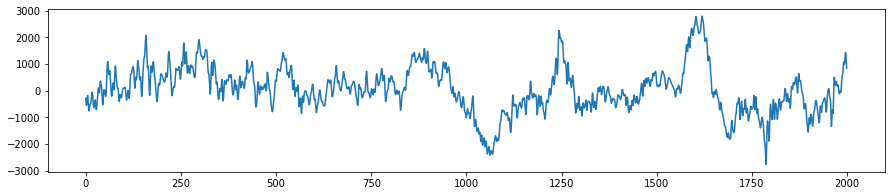

In [8]:
# # test bandpass / downsampling
session     = sessions[0]
area        = 'A1'
animal      = session.split('_')[0]
aeps_file   = os.path.join(source, animal, session, 'AEPs.h5')
    
with h5py.File(aeps_file, 'r') as f:
    lfp = np.array(f[area]['LFP'])
    
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(lfp[33000:35000])  # 3 seconds

In [89]:
# with h5py.File(aeps_file, 'a') as f:
#     f['PPC'] = f['0']
#     del f['0']

## Extract AEP events

In [201]:
# def build_event_mx(tl, offset, latency):
#     drift_coeff = 0.055/2400
#     duration = tl[-1][0]
#     drift = duration * drift_coeff
    
#     # all pulses with drift
#     pulse_times = np.array([i*latency for i in range(int((duration - latency)/latency) + 10)]) + offset
#     pulse_times += np.arange(len(pulse_times)) * drift/len(pulse_times)
#     pulse_times = pulse_times[pulse_times < duration]  # filter out if more pulses
    
#     event_mx = np.zeros([len(pulse_times), 2])
#     tl_idx = 0  # index of current pulse in the timeline
#     for i, t_pulse in enumerate(pulse_times):
#         while tl[tl_idx][0] < t_pulse:
#             tl_idx += 1

#         event_mx[i] = np.array([t_pulse, tl[tl_idx][6]])
#     return event_mx[:-1]

In [202]:
## LEGACY !!!!

# sound timing correction array
def get_correction_for_sounds(events, offset, corr=55):
    # N1 should be at 20ms
    # then if N1 is from 33 to 88 correction should be from 13 to 68 ms
    duration = events[-1][0] - events[0][0]
    corrected = np.array([offset + corr*(t/duration) for t in events[:, 0]]) / 1000 # to get it in seconds
    return corrected

# get sound events
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    events = np.array(f['raw']['sounds'])

# normalize time to session start
events[:, 0] -= events[0][0]

# select only target / background presentations
#events = events[(events[:, 1] == 1) | (events[:, 1] == 2)]
events = events[:-1]
print(len(events))

events_corrected = np.zeros(events.shape)
events_corrected[:, 1] = events[:, 1]
events_corrected[:, 0] = events[:, 0] + get_correction_for_sounds(events, offset=offset_corr)

9007


In [203]:
session     = sessions[0]
latency     = 0.333  # IPI duration in sec
down_s_rate = 1000   # LFP samp rate Hz
offset_corr = 0.2    # in seconds!!

animal      = session.split('_')[0]
aeps_file   = os.path.join(source, animal, session, 'AEPs.h5')
h5_file     = os.path.join(source, animal, session, session + '.h5')
session

with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    
event_mx = build_event_mx(tl, offset_corr, latency)
event_mx.shape

(9008, 2)

In [204]:
# save AEPs to file
with h5py.File(aeps_file, 'a') as f:
    if 'aeps_events' in f:
        del f['aeps_events']
        
    f.create_dataset('aeps_events', data=event_mx)

## Extract AEPs from downsampled LFP

In [206]:
areas = ['A1', 'PPC']

aeps_all = {}
for area in areas:
    # get LFP
    with h5py.File(aeps_file, 'r') as f:
        down_signal = np.array(f[area]['LFP'])
        aeps_events = np.array(f['aeps_events'])
    
    # constructing AEP matrix
    aeps = np.zeros([len(aeps_events), int(latency*down_s_rate)])
    for i, event in enumerate(aeps_events):
        idx_event = int(event[0]*down_s_rate)
        aeps[i] = down_signal[idx_event:idx_event + int(latency*down_s_rate)]

    # save AEPs to file
    with h5py.File(aeps_file, 'a') as f:
        if 'aeps' in f:
            del f['aeps']
        if 'aeps' in f[area]:
            del f[area]['aeps']

        f[area].create_dataset('aeps', data=aeps)
        
    aeps_all[area] = aeps

### Plot to test

In [226]:
def get_bootstrapped(area, idxs, split_ratio=0.5):
    count_A = int(len(idxs)*split_ratio)
    #count_B = len(idxs) - count_A

    iter_count = 100
    boot_mx = np.zeros([iter_count, len(aeps_all[area][0])])
    for i in range(iter_count):
        idxs_A = np.random.choice(idxs, count_A, replace=False)
        #idxs_B = np.array([x for x in idxs if not x in idxs_A])
        boot_mx[i] = aeps_all[area][idxs_A].mean(axis=0)
        
    return boot_mx

# select AEPs plus do conf intervals
aeps_all = {}
with h5py.File(aeps_file, 'r') as f:
    aeps_events = np.array(f['aeps_events'])
    for area in areas:
        aeps_all[area] = np.array(f[area]['aeps'])
        
idxs_events_before = np.where((aeps_events[:, 0] < 600))[0]
idxs_events_stim   = np.where((aeps_events[:, 0] > 600) & (aeps_events[:, 0] < 2400))[0]
idxs_events_after  = np.where((aeps_events[:, 0] > 2400) & (aeps_events[:, 0] < 2900))[0]

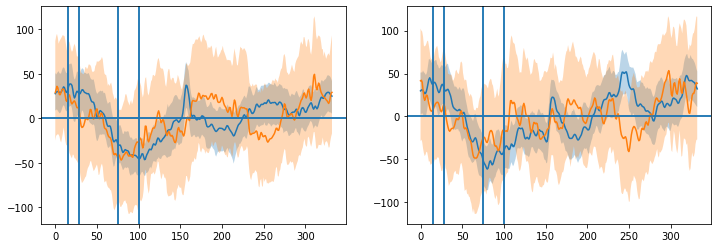

In [235]:
fig, axes = plt.subplots(1, len(areas), figsize=(6*len(areas), 4))

for j, idxs in enumerate([idxs_events_stim, idxs_events_before]):
    for i, area in enumerate(areas):
        boot_mx = get_bootstrapped(area, idxs)
        confidence_low  = np.zeros(boot_mx.shape[1])
        confidence_high = np.zeros(boot_mx.shape[1])
        for k, col in enumerate(boot_mx.T):
            confidence_low[k]  = np.percentile(col, 5)
            confidence_high[k] = np.percentile(col, 95)

        x_vals = np.arange(boot_mx.shape[1])
        ax = axes[i]
        ax.plot(x_vals, boot_mx.mean(axis=0))
        ax.fill_between(x_vals, confidence_low, confidence_high, alpha=0.3)
        ax.axvline(15)
        ax.axvline(28)
        ax.axvline(75)
        ax.axvline(100)
        ax.axhline(0)
        ax.grid()

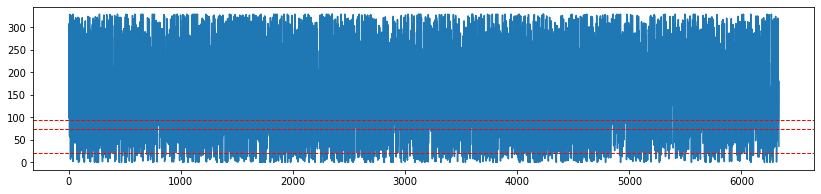

In [18]:
# Check drift of sound pulses - plot AEP min positions
mins = aeps.argmin(axis=1)
t_P1 = 20

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
ax.plot(mins)
#plt.ylim(60, 100)
plt.axhline(t_P1, color='red', ls='--', lw=1)
plt.axhline(75, color='red', ls='--', lw=1)
plt.axhline(95, color='red', ls='--', lw=1)
#plt.plot([0, 6643], [33, 88])

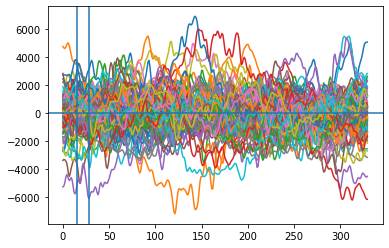

In [19]:
fig, ax = plt.subplots(1, 1)
for aep in aeps[100:200]:
    ax.plot(aep)
ax.axvline(15)
ax.axvline(28)
ax.axhline(0)

(array([945., 266., 261., 281., 291., 257., 259., 236., 251., 265., 228.,
        235., 259., 234., 241., 254., 221., 263., 255., 833.]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ]),
 <BarContainer object of 20 artists>)

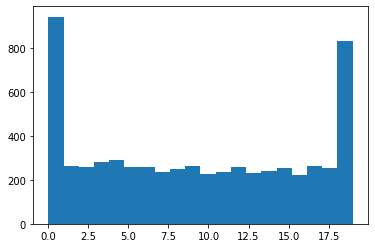

In [20]:
argmins = aeps[:, 20:40].argmin(axis=1)
plt.hist(argmins, bins=20)

## P1, N1, P2, P3 metrics extraction

In [27]:
def get_metric(aeps, t_l, t_r, k_width=20):
    # extracts areas for a given time window
    # returns original and smoothed/normed areas
    def to_normed(data):
        normed = data - data.min() 
        return normed/(normed.max() - normed.min())

    # extracting interval values
    metric = aeps[:, t_l:t_r].sum(axis=1)
    m_mean, m_std = metric.mean(), metric.std()
    metric[metric > m_mean + 3*m_std] = m_mean + 3*m_std
    metric[metric < m_mean - 3*m_std] = m_mean - 3*m_std
    
    # z-scored
    metric_z = stats.zscore(metric)
    
    # smoothed
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    metric_smooth = np.convolve(metric_z, kernel, 'same') / kernel.sum()
    
    return metric, metric_smooth #to_normed(metric_smooth)

In [28]:
def compute_metric(aeps, method, t_l, t_r, k_width=20):

    metric = np.zeros(len(aeps))    
    if method == 0:  # min - max to the left of min
        min_idxs = aeps[:, t_l:t_r].argmin(axis=1)
        for i, idx in enumerate(min_idxs):
            if idx > 0:
                m_max = aeps[i][t_l:t_l + idx].max()
                m_min = aeps[i][t_l + idx]
                metric[i] = m_min - m_max
    elif method == 1:
        max_idxs = aeps[:, t_l:t_r].argmax(axis=1)
        for i, idx in enumerate(max_idxs):
            if idx > 0:
                m_min = aeps[i][t_l:t_l + idx].min()
                m_max = aeps[i][t_l + idx]
                metric[i] = m_max - m_min
    else:
        metric = aeps[:, t_l:t_r].sum(axis=1)
        
    m_mean, m_std = metric.mean(), metric.std()
    metric[metric > m_mean + 3*m_std] = m_mean + 3*m_std
    metric[metric < m_mean - 3*m_std] = m_mean - 3*m_std
    
    # z-scored
    metric_z = stats.zscore(metric)
    
    # smoothed
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    metric_smooth = np.convolve(metric_z, kernel, 'same') / kernel.sum()
    
    return metric, metric_smooth

In [29]:
AEP_metrics_lims = {
    'A1': {
        'P1': [15, 28],  # min - max to the left of min
        'N1': [28, 73],  # AUC
        'P2': [73, 100], # AUC
        'P3': [100, 200] # AUC
    },
    'PPC': {
        'P0': [10, 15], # min - max to the left of min
        'N0': [15, 20], # max - min to the left of max
        'P1': [20, 40], # min - max to the left of min
        'N1': [40, 75], # max - min to the left of max
        'P3': [75, 160] # AUC
    },
    'HPC': {
        'P0': [10, 15], # min - max to the left of min
        'N0': [15, 20], # max - min to the left of max
        'P1': [20, 40], # min - max to the left of min
        'N1': [40, 75], # max - min to the left of max
        'P3': [75, 160] # min - max to the left of min
    }
}

# 0 - min - max to the left of min, 1 - max - min to the left of max, 2 - AUC
AEP_metrics_methods = {
    'A1':  {'P1': 2, 'N1': 2, 'P2': 2, 'P3': 2},
    'PPC': {'P0': 0, 'N0': 1, 'P1': 0, 'N1': 1, 'P3': 2},
    'HPC': {'P0': 0, 'N0': 1, 'P1': 0, 'N1': 1, 'P3': 0},
}

In [32]:
area     = 'PPC'
outlier  = 1500
selected = sessions
selected

['60_SIT_2023-11-24_17-09-10']

In [33]:
for session in selected:
    animal      = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
    
    with h5py.File(aeps_file, 'r') as f:
        aeps = np.array(f[area]['aeps'])
        aeps_events = np.array(f['aeps_events'])
        
    # remove outliers
    aeps[aeps >  outlier]  = outlier
    aeps[aeps < -outlier] = -outlier

    metrics_raw, metrics_norm  = {}, {}
    for m_name, bounds in AEP_metrics_lims[area].items():
        method = AEP_metrics_methods[area][m_name]
        m_raw, m_norm = compute_metric(aeps, method, bounds[0], bounds[1])
        metrics_raw[m_name]  = m_raw
        metrics_norm[m_name] = m_norm
        
    # save metrics to file
    with h5py.File(aeps_file, 'a') as f:
        grp = f[area]
        if not 'raw' in grp:
            grp.create_group('raw')
        if not 'norm' in grp:
            grp.create_group('norm')

        for m_del_name in ['P0', 'N0', 'P1', 'N1', 'P2', 'N2', 'P3', 'N3']:
            if m_del_name in grp['norm']:
                del grp['norm'][m_del_name]
            if m_del_name in grp['raw']:
                del grp['raw'][m_del_name]

        for m_name in metrics_raw.keys():
            if m_name in grp['raw']:
                del grp['raw'][m_name]
            if m_name in grp['norm']:
                del grp['norm'][m_name]
            
            lims_as_str = ','.join([str(x) for x in AEP_metrics_lims[area][m_name]]) 
            d = grp['raw'].create_dataset(m_name, data=metrics_raw[m_name])
            d.attrs['limits'] = lims_as_str
            d = grp['norm'].create_dataset(m_name, data=metrics_norm[m_name])
            d.attrs['limits'] = lims_as_str
            grp.attrs['limits'] = lims_as_str
           
    print('Session %s done' % session)

Session 60_SIT_2023-11-24_17-09-10 done


## Extraction of 4Hz LFP phase / amplitude

In [4]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [25]:
selected = selected_009266

In [26]:
all_areas   = ['A1', 'PPC', 'HPC']

for session in selected:
    animal      = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
    h5_file     = os.path.join(sessionpath, session + '.h5')

    # collect LFP
    lfp = {}
    with h5py.File(aeps_file, 'r') as f:
        for area in all_areas:
            if not area in f:
                continue
            lfp[area]  = np.array(f[area]['LFP'])

    # filter 4Hz
    s_rate = 1000  # original LFP
    low_cut  = 3.9  # Hz
    high_cut = 4.1 # Hz
    lfps4Hz = {}
    sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
    for area, sig in lfp.items():
        lfps4Hz[area] = signal.sosfiltfilt(sos, sig)

    # phase / amplitude
    hilbert = {}
    for area, lfp4Hz in lfps4Hz.items():
        hilbert[area] = {}
        a_signal = signal.hilbert(lfp4Hz)     # hilbert transform
        hilbert[area]['envelope'] = np.abs(a_signal)    # amplitude envelope
        hilbert[area]['phase']    = np.angle(a_signal) # instantaneous phase


    # save to AEPs file
    with h5py.File(aeps_file, 'a') as f:
        for area, lfp4Hz in lfps4Hz.items():
            if not 'LFP4Hz' in f[area]:
                f[area].create_group('LFP4Hz')

            grp = f[area]['LFP4Hz']
            for name in ['lfp', 'envelope', 'phase']:
                if name in grp:
                    del grp[name]

            grp.create_dataset('lfp', data=lfps4Hz[area])
            grp.create_dataset('envelope', data=hilbert[area]['envelope'])
            grp.create_dataset('phase', data=hilbert[area]['phase'])

    print("Session %s done" % session)

Session 009266_hippoSIT_2023-04-17_17-04-17 done
Session 009266_hippoSIT_2023-04-18_10-10-37 done
Session 009266_hippoSIT_2023-04-18_17-03-10 done
Session 009266_hippoSIT_2023-04-19_10-33-51 done
Session 009266_hippoSIT_2023-04-24_16-56-55 done
Session 009266_hippoSIT_2023-05-02_12-22-14 done
Session 009266_hippoSIT_2023-04-20_08-57-39 done
Session 009266_hippoSIT_2023-04-26_08-20-17 done
Session 009266_hippoSIT_2023-05-04_19-47-15 done
Session 009266_hippoSIT_2023-04-20_15-24-14 done
Session 009266_hippoSIT_2023-04-21_08-43-00 done
Session 009266_hippoSIT_2023-04-21_13-12-31 done
Session 009266_hippoSIT_2023-04-24_10-08-11 done
Session 009266_hippoSIT_2023-05-04_09-11-06 done
Session 009266_hippoSIT_2023-05-22_09-27-22 done
Session 009266_hippoSIT_2023-05-23_09-18-05 done
Session 009266_hippoSIT_2023-05-25_15-55-57 done
Session 009266_hippoSIT_2023-06-14_08-21-23 done
Session 009266_hippoSIT_2023-06-19_08-58-35 done


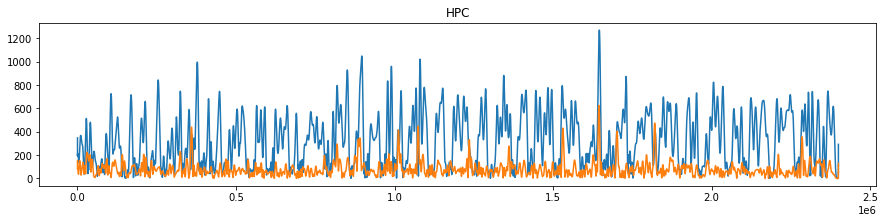

In [27]:
# visualize one to test
envelopes = {}
with h5py.File(aeps_file, 'r') as f:
    for area in all_areas:
        if not area in f:
            continue
        envelopes[area] = np.array(f[area]['LFP4Hz']['envelope'])
        
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for area, env in envelopes.items():
    ax.plot(env)
    ax.set_title(area)

## Copy from previous

In [11]:
selected_sessions = [
# new dual A1 / PPC sessions
'009266_hippoSIT_2023-04-17_17-04-17',  # ch17, 20 + 55 correction, 5067 events
'009266_hippoSIT_2023-04-18_10-10-37',  # ch17, 10 + 55 correction, 5682 events
'009266_hippoSIT_2023-04-18_17-03-10',  # ch17, 6 + 55 correction, 5494 events
'009266_hippoSIT_2023-04-19_10-33-51',  # ch17, 4 + 55 correction, 6424 events
'009266_hippoSIT_2023-04-20_08-57-39',  # ch1, 1 + 55 correction, 6424 events
'009266_hippoSIT_2023-04-24_16-56-55',  # ch17, 5 + 55* correction, 6165 events, frequency
'009266_hippoSIT_2023-04-26_08-20-17',  # ch17, 12 + 55* correction, 6095 events, duration
'009266_hippoSIT_2023-05-02_12-22-14',  # ch20, 10 + 55 correction, 5976 events, frequency
'009266_hippoSIT_2023-05-04_09-11-06',  # ch17, 5 + 55* correction, 4487 events, coma session with baseline AEPs
'009266_hippoSIT_2023-05-04_19-47-15',  # ch20, 2 + 55 correction, 5678 events, frequency

# old PPC data
#'008229_hippoSIT_2022-05-17_21-44-43', #0 # chs: 0, 31, 54, 56
#'008229_hippoSIT_2022-05-16_20-36-44', #0 # chs: 0, 56
#'008229_hippoSIT_2022-05-20_15-54-39', #0 # chs: 0, 56
#'008229_hippoSIT_2022-05-18_14-36-18', #0 # chs: 0, 56
]

In [13]:
for session in selected_sessions:
    animal      = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    aeps_file   = os.path.join(sessionpath, 'AEPs.h5')

    with h5py.File(aeps_file, 'r') as f:
        aeps_events = np.array(f['aeps_events'])
        LFP = np.array(f['LFP'])
        aeps = np.array(f['aeps'])

    with h5py.File(aeps_file, 'a') as f:
        if 'A1' in f:
            del f['A1']

        grp = f.create_group('A1')
        grp.create_dataset('LFP', data=LFP)
        grp.create_dataset('aeps', data=aeps)
        
    print("session %s done" % session)

session 009266_hippoSIT_2023-04-17_17-04-17 done
session 009266_hippoSIT_2023-04-18_10-10-37 done
session 009266_hippoSIT_2023-04-18_17-03-10 done
session 009266_hippoSIT_2023-04-19_10-33-51 done
session 009266_hippoSIT_2023-04-20_08-57-39 done
session 009266_hippoSIT_2023-04-24_16-56-55 done
session 009266_hippoSIT_2023-04-26_08-20-17 done
session 009266_hippoSIT_2023-05-02_12-22-14 done
session 009266_hippoSIT_2023-05-04_09-11-06 done
session 009266_hippoSIT_2023-05-04_19-47-15 done


In [ ]:
    # special for duration
#     aeps_tgt = aeps[aeps_events[:, 1] == 2]
#     P2_raw_tgt, P2_norm_tgt = get_P2_duration(aeps_tgt, metric_lims['P2'][0] + 40, metric_lims['P2'][1] + 40)
#     P2_raw_all  = metrics_raw['P2']
#     P2_norm_all = metrics_norm['P2']
#     P2_raw_all[aeps_events[:, 1] == 2] = P2_raw_tgt
#     P2_norm_all[aeps_events[:, 1] == 2] = P2_norm_tgt
#     P3_raw_all  = metrics_raw['P3']
#     P3_norm_all = metrics_norm['P3']
#     P3_raw_all[aeps_events[:, 1] == 2]  -= P2_raw_tgt
#     P3_norm_all[aeps_events[:, 1] == 2] -= P2_norm_tgt
    
#     metrics_raw['P2']  = P2_raw_all
#     metrics_norm['P2'] = P2_norm_all
#     metrics_raw['P3']  = P3_raw_all
#     metrics_norm['P3'] = P3_norm_all

In [4]:
def get_P2_duration(aeps, t_l, t_r, k_width=20):
    metric = np.zeros(len(aeps))
    for i, aep in enumerate(aeps):
        y_max = np.max([aep[t_l], aep[t_r]])
        aep_mod = aep[t_l:t_r] - y_max
        metric[i] = aep_mod.sum()
    
    # z-scored
    metric_z = stats.zscore(metric)
    
    # smoothed
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    metric_smooth = np.convolve(metric_z, kernel, 'same') / kernel.sum()
    
    return metric, metric_smooth #to_normed(metric_smooth)